In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
cleaned_matches = pd.read_csv(data)


In [4]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26122 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             26122 non-null  object        
 1   Date            26122 non-null  datetime64[ns]
 2   Home/Away       26122 non-null  object        
 3   Opponent        26122 non-null  object        
 4   Score           26122 non-null  object        
 5   W/L/T           26122 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        26122 non-null  object        
 8   Venue           26122 non-null  object        
 9   Attendance      26098 non-null  float64       
 10  Notes           1061 non-null   object        
 11  Opponent Code   26122 non-null  object        
 12  Team            26122 non-null  object        
 13  Team Code       26122 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

## Train to classify based on the last-n-games a team played

In [5]:
x_cols = [
    'Team Code',
    'Opponent Code'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score'
]
y_cols = [
    'Class'
]

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)
played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25942 entries, 0 to 26121
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             25942 non-null  object        
 1   Date            25942 non-null  datetime64[ns]
 2   Home/Away       25942 non-null  object        
 3   Opponent        25942 non-null  object        
 4   Score           25942 non-null  object        
 5   W/L/T           25942 non-null  object        
 6   Overtime        948 non-null    object        
 7   Location        25942 non-null  object        
 8   Venue           25942 non-null  object        
 9   Attendance      25918 non-null  float64       
 10  Notes           1051 non-null   object        
 11  Opponent Code   25942 non-null  object        
 12  Team            25942 non-null  object        
 13  Team Code       25942 non-null  object        
 14  Team Score      25942 non-null  float64       
 15  Op

In [6]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, ['Team Score', 'Opponent Score'])


.................................................
 Done


In [7]:
X = pd.concat([pd.get_dummies(last_n_matches[xcol], prefix='_'.join(
    xcol.split())+'_') for xcol in x_cols] + [last_n_matches[lookup_x_cols + new_columns]], axis=1)
y = last_n_matches[y_cols]


In [8]:
X.describe()

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Team Code_p_Team Score,Team Code_pp_Team Score,Team Code_ppp_Team Score,Team Code_pppp_Team Score,Team Code_ppppp_Team Score,Team Code_p_Opponent Score,Team Code_pp_Opponent Score,Team Code_ppp_Opponent Score,Team Code_pppp_Opponent Score,Team Code_ppppp_Opponent Score
count,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,...,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000,25787.000000
mean,0.015201,0.029782,0.030636,0.029433,0.049444,0.012913,0.028697,0.041028,0.036259,0.029084,...,20.564121,20.526195,20.552139,20.520146,20.537247,20.511459,20.526040,20.505565,20.514639,20.500950
std,0.122356,0.169990,0.172332,0.169021,0.216796,0.112904,0.166956,0.198360,0.186936,0.168046,...,10.570357,10.565047,10.570280,10.569637,10.572947,10.571572,10.578987,10.577203,10.583073,10.582607
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000


In [9]:
y.head()

,Class
25,1
29,1
31,1
32,0
33,1


In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X.to_numpy(), y.to_numpy(), test_pct=0.2, val_pct=0.2, random_state=0
)

y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(15471, 74) (15471,)
(5158, 74) (5158,)
(5158, 74) (5158,)


In [11]:
maxima = X_train.max(axis=0)
minima = X_train.min(axis=0)
numerical = (maxima > 1) | (minima < 0)
mean = np.mean(X_train[:, numerical])
std = np.std(X_train[:, numerical])
X_train[:, numerical] = (X_train[:, numerical] - mean) / std
X_train[:, numerical]


array([[-1.94141287,  1.36690271, -0.05094682, ..., -0.71260994,
         2.21761243, -1.37427306],
       [ 0.23262308, -0.05094682,  2.02856583, ..., -1.27974976,
        -0.61808664,  1.93404253],
       [-0.99617985, -0.05094682, -0.99617985, ..., -0.61808664,
        -1.09070315, -0.99617985],
       ...,
       [ 0.51619299,  0.61071629, -0.61808664, ..., -0.33451673,
        -1.65784296,  0.9888095 ],
       [ 0.9888095 ,  1.17785611,  0.61071629, ...,  0.32714639,
         1.46142601, -0.52356334],
       [-0.05094682,  0.04357648,  1.55594932, ..., -0.71260994,
        -1.27974976,  0.32714639]])

In [39]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    train_scores = []
    val_scores = []
    val_space = np.geomspace(start=0.01, stop=2, num=5)
    for C in val_space:
        print(f"Evaluating {kernel} kernel for C={C}")
        model = svm.SVC(C=C, max_iter=10_000, kernel=kernel)

        model.fit(X_train, y_train)
        train_scores.append(model.score(X_train, y_train))
        val_scores.append(model.score(X_val, y_val))

    plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
    plt.plot(val_space, train_scores, label='Train score')
    plt.plot(val_space, val_scores, label='Val score')
    # plt.ylim(0, 1.1)
    plt.xscale('log')
    plt.legend()
    plt.show()


Evaluating linear kernel for C=0.01


KeyboardInterrupt: 

In [37]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = model.predict(X_test)
precision, recall, fbeta_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.9809014514896868, 1.0, 0.9903586579251832, None)

In [17]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

# best_config = []
# best_score = 0
# best_fit_config = []
# best_fit_score = 0
# for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=62), DecisionTreeClassifier(max_leaf_nodes=124)]:
#   for nestimators in [10, 31, 62, 93, 124]:
#     for nsamples in [10, 20, 30, 50]:
#       regressor = BaggingRegressor(base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples)
#       regressor.fit(X_train, y_train)
      
#       score = regressor.score(X_val, y_val)
#       if(score > best_score):
#         best_config = [estimator, nestimators, nsamples]
#         best_score = score
      
#       score = regressor.score(X_train, y_train)
#       if(score > best_fit_score):
#         best_fit_config = [estimator, nestimators, nsamples]
#         best_fit_score = score
        
#       print(end='.')

In [15]:
# print(f"Best validation: {best_score}, {best_config}")
# print(f"Best training: {best_fit_score}, {best_fit_config}")

In [18]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.5480806514152773

In [19]:
clf.predict_proba(X_test[0:1])

array([[1., 0.]])

In [20]:
team_opponent_codes = X.columns[:-(len(lookup_x_cols) + len(new_columns))]
n_team_codes = len(team_opponent_codes) // 2
opponent_codes, team_codes = team_opponent_codes[n_team_codes:], team_opponent_codes[:n_team_codes]
print(n_team_codes)
print(opponent_codes)
print(team_codes)

31
Index(['Opponent_Code__ari', 'Opponent_Code__atl', 'Opponent_Code__bal',
       'Opponent_Code__buf', 'Opponent_Code__chib', 'Opponent_Code__chic',
       'Opponent_Code__cin', 'Opponent_Code__cle', 'Opponent_Code__dal',
       'Opponent_Code__den', 'Opponent_Code__det', 'Opponent_Code__gb',
       'Opponent_Code__hou', 'Opponent_Code__ind', 'Opponent_Code__kc',
       'Opponent_Code__larm', 'Opponent_Code__mia', 'Opponent_Code__min',
       'Opponent_Code__ne', 'Opponent_Code__no', 'Opponent_Code__nyg',
       'Opponent_Code__nyj', 'Opponent_Code__oak', 'Opponent_Code__phi',
       'Opponent_Code__pit', 'Opponent_Code__sd', 'Opponent_Code__sea',
       'Opponent_Code__sf', 'Opponent_Code__stl', 'Opponent_Code__tb',
       'Opponent_Code__was'],
      dtype='object')
Index(['Team_Code__ari', 'Team_Code__atl', 'Team_Code__bal', 'Team_Code__buf',
       'Team_Code__chib', 'Team_Code__chic', 'Team_Code__cin',
       'Team_Code__cle', 'Team_Code__dal', 'Team_Code__den', 'Team_Code__det'

In [21]:
teams = X[team_codes]
opponents = X[opponent_codes]

codes = team_codes.str.split('__')
teams.columns = [code[1] for code in codes]

codes = opponent_codes.str.split('__')
opponents.columns = [code[1] for code in codes]

<AxesSubplot:>

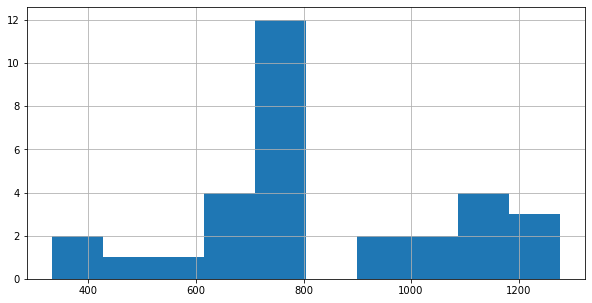

In [22]:
teams.sum(axis=0).hist()

<AxesSubplot:>

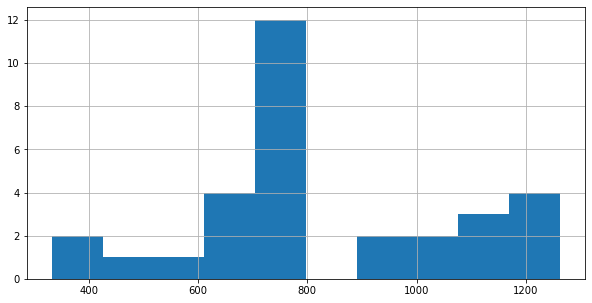

In [23]:
opponents.sum(axis=0).hist()

<AxesSubplot:>

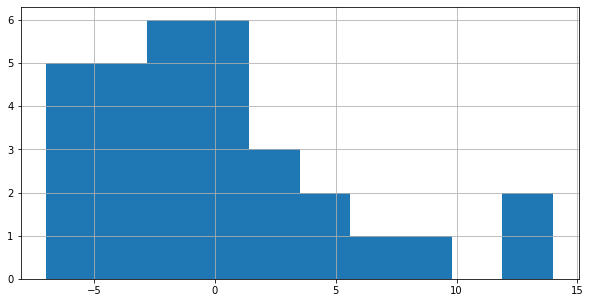

In [24]:
(teams.sum(axis=0) - opponents.sum(axis=0)).hist()

In [25]:
unique_teams = X.groupby(team_opponent_codes.to_list()).size().reset_index(name="Count").sort_values('Count').reset_index(drop=True)

In [26]:
unique_teams

,Team_Code__ari,Team_Code__atl,Team_Code__bal,Team_Code__buf,Team_Code__chib,Team_Code__chic,Team_Code__cin,Team_Code__cle,Team_Code__dal,Team_Code__den,...,Opponent_Code__oak,Opponent_Code__phi,Opponent_Code__pit,Opponent_Code__sd,Opponent_Code__sea,Opponent_Code__sf,Opponent_Code__stl,Opponent_Code__tb,Opponent_Code__was,Count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,176
901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,176
902,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,176
903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,196


In [ ]:
for _, row in unique_teams.iterrows():
    mask = row > 0
    elements = row[mask]
    print(' '.join([elem.split('__')[1] for elem in elements.index[:-1]]), elements[-1])


no no 1.0
kc kc 1.0
stl chic 1.0
ne ne 1.0
sea chic 1.0
chic bal 1.0
sd chic 1.0
tb chic 1.0
sf chic 2.0
chic kc 2.0
kc chic 2.0
chic sf 2.0
buf chic 3.0
cin chic 3.0
ind larm 3.0
larm ind 3.0
oak larm 4.0
larm oak 4.0
chic cin 4.0
chic buf 4.0
ind stl 5.0
ind ari 5.0
buf ari 5.0
hou ari 5.0
ari ind 5.0
sd larm 5.0
ari hou 5.0
chic min 5.0
ari buf 5.0
stl ind 6.0
oak stl 6.0
kc larm 6.0
stl oak 6.0
larm sd 6.0
nyj ari 6.0
larm kc 6.0
mia ari 6.0
ari nyj 6.0
ari cle 6.0
ne ari 6.0
ari mia 6.0
min chic 6.0
ari ne 6.0
bal ari 7.0
cle ari 7.0
hou stl 7.0
den ari 7.0
oak ari 7.0
larm buf 7.0
tb bal 7.0
mia larm 7.0
ari oak 7.0
larm mia 7.0
ari bal 7.0
buf larm 7.0
ind min 7.0
min ind 7.0
ari den 7.0
ari sd 7.0
sd ari 7.0
stl hou 7.0
bal sea 8.0
stl den 8.0
ari larm 8.0
bal tb 8.0
pit ari 8.0
larm ne 8.0
larm nyj 8.0
oak was 8.0
ari kc 8.0
den stl 8.0
nyj larm 8.0
hou larm 8.0
kc phi 8.0
ari cin 8.0
larm cin 8.0
larm den 8.0
larm hou 8.0
den larm 8.0
kc ari 8.0
nyg ind 8.0
ind nyg 8.0
ari pi